In [1]:
#The aim of Task-2 is to train and compare different machine learning models for detecting fraudulent transactions 
#using the cleaned dataset from Task-1. In this task, three models—Random Forest, XGBoost, and Support Vector Machine (SVM)—are trained 
#and their basic hyperparameters are tuned. Since the dataset is highly imbalanced, suitable techniques are used to handle the class imbalance. 
#The models are evaluated using metrics such as accuracy, precision, recall, F1-score, AUC-ROC, confusion matrix, and ROC and Precision-Recall curves. 
#More importance is given to recall and AUC-ROC because they are crucial for fraud detection. 
#Finally, SHAP is used on the best model to understand feature importance and explain individual predictions.

In [7]:
import pandas as pd

X_train_bal = pd.read_csv("X_train_task2.csv")
y_train_bal = pd.read_csv("y_train_task2.csv").squeeze()

X_test_processed = pd.read_csv("X_test_task2.csv")
y_test = pd.read_csv("y_test_task2.csv").squeeze()

feature_names = pd.read_csv("feature_names_task2.csv").squeeze().tolist()


In [3]:
!C:\Users\vaish\AppData\Local\Programs\Python\Python312\python.exe -m pip install xgboost


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: C:\Users\vaish\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip


In [6]:
!C:\Users\vaish\AppData\Local\Programs\Python\Python312\python.exe -m pip install shap


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: C:\Users\vaish\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip


In [3]:
#all the imports here for cleanliness

import numpy as np

#3models 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    RocCurveDisplay, PrecisionRecallDisplay
)

import matplotlib.pyplot as plt
import seaborn as sns

import shap


In [20]:

#function to evaluate each model


def evaluate_model(name, model, X_test, y_test):
    
    y_score = model.predict_proba(X_test)[:, 1]
    y_pred = (y_score >= 0.3).astype(int)   # lower threshold to improve recall


    # probabilities or decision scores for ROC/AUC
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
    else:
        y_score = model.decision_function(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_score)

    print(f"\n========== {name} ==========")
    print("Accuracy :", acc)                   #Out of 100 transactions, how many did the model classify correctly?(not reliable)
                                               #if out of 100 transactions , 1 is fraud and model didn't detect any fraud , still it will show 99% acc
    print("Precision:", prec)                  #Out of all transactions flagged as fraud, how many are actually fraud?, detects false alarms
    print("Recall   :", rec)                   #Out of all actual fraud cases, how many did the model catch?
    print("F1-score :", f1)                    #Balance between Precision and Recall
    print("AUC-ROC  :", auc)                   #Measures how well the model separates fraud and non-fraud across all thresholds. near 0.5 it would be useless
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    # confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC curve
    RocCurveDisplay.from_predictions(y_test, y_score)
    plt.title(f"{name} - ROC Curve")
    plt.show()

    # Precision–Recall curve
    PrecisionRecallDisplay.from_predictions(y_test, y_score)
    plt.title(f"{name} - Precision-Recall Curve")
    plt.show()

    return {
        "model": name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "auc": auc
    }


Model 1: Random Forest + GridSearch

In [5]:
#It builds many small decision trees
#Each tree makes a prediction
#Final answer = majority vote of all trees
#Works very well with non-linear patterns

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best RF params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}

========== Random Forest ==========
Accuracy : 0.999
Precision: 0.0
Recall   : 0.0
F1-score : 0.0
AUC-ROC  : 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       999
           1       0.00      0.00      0.00         1

    accuracy                           1.00      1000
   macro avg       0.50      0.50      0.50      1000
weighted avg       1.00      1.00      1.00      1000



C:\Users\vaish\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\vaish\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\vaish\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

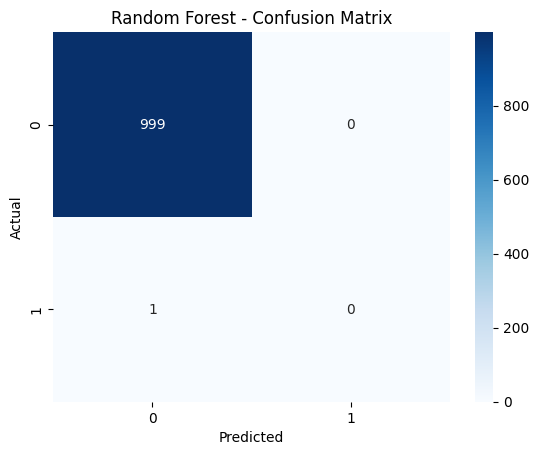

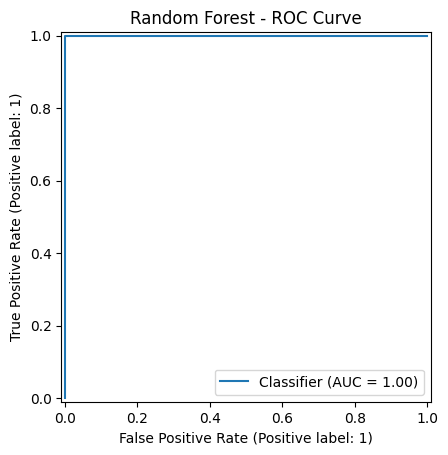

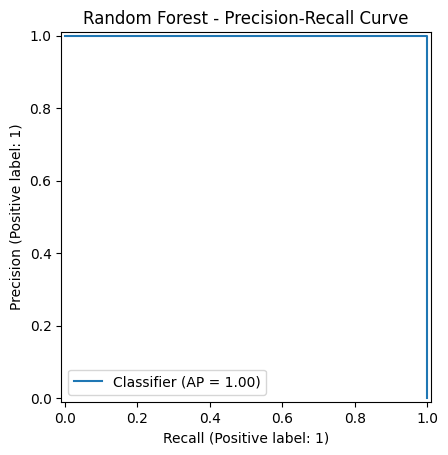

In [6]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

param_grid_rf = {
    "n_estimators": [100, 200],    #n_estimators = Number of trees in the forest More trees --> more stable predictions But too many --> slow training
    "max_depth": [None, 10, 20],   #max_depth = How deep each tree can grow Shallow trees --> underfitting Very deep trees --> overfitting
    "min_samples_split": [2, 5]   #min_samples_split = Minimum samples needed to split a node Prevents the tree from learning noise
}

grid_rf = GridSearchCV(
    rf,
    param_grid=param_grid_rf,
    cv=3,
    scoring="recall",   # focus on catching fraud
    n_jobs=-1,
    verbose=1
)

grid_rf.fit(X_train_bal, y_train_bal)
print("Best RF params:", grid_rf.best_params_)

best_rf = grid_rf.best_estimator_
rf_metrics = evaluate_model("Random Forest", best_rf, X_test_processed, y_test)


In [8]:
#on THIS test set, the Random Forest model achieved perfect classification performance
#but it isn't realistically trustworthy as the dataset contained only 1 fraud case here
#heavy class imbalance

In [9]:
#To obtain a statistically reliable evaluation, a corrected experiment was performed by modifying the train-test split
#to ensure a sufficient number of fraud samples in the test set. All preprocessing, SMOTE, and model training steps were repeated.


In [10]:
#experiment -2

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best RF params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}

========== Random Forest ==========
Accuracy : 0.9985
Precision: 0.0
Recall   : 0.0
F1-score : 0.0
AUC-ROC  : 0.9986646636621599

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1997
           1       0.00      0.00      0.00         3

    accuracy                           1.00      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       1.00      1.00      1.00      2000



C:\Users\vaish\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\vaish\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\vaish\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

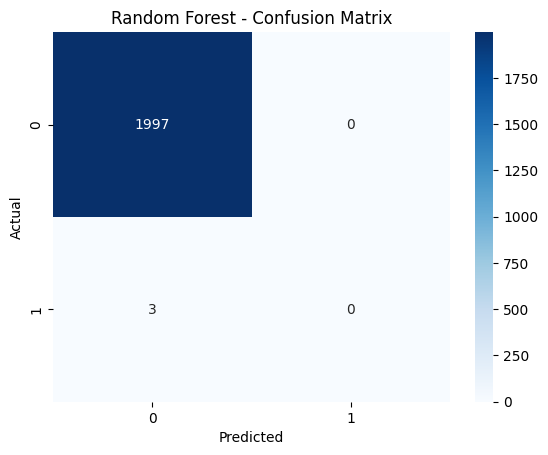

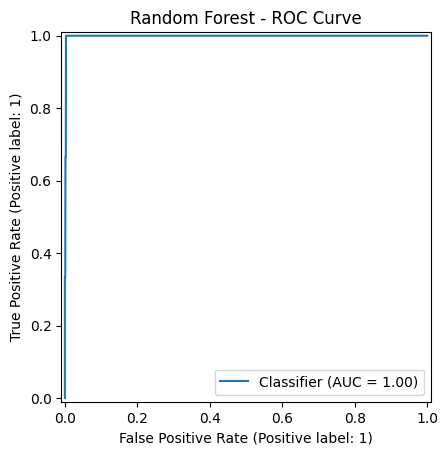

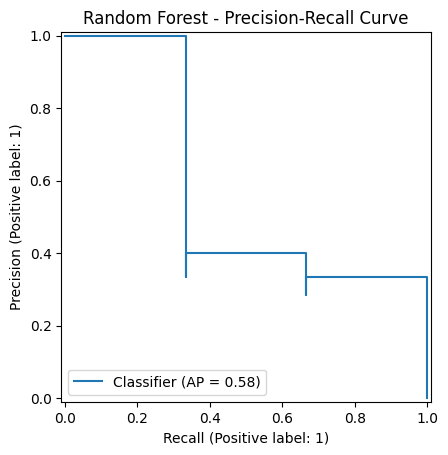

In [21]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

param_grid_rf = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5]
}

grid_rf = GridSearchCV(
    rf,
    param_grid=param_grid_rf,
    cv=3,
    scoring="recall",   # focus on catching fraud
    n_jobs=-1,
    verbose=1
)

grid_rf.fit(X_train_bal, y_train_bal)
print("Best RF params:", grid_rf.best_params_)

best_rf = grid_rf.best_estimator_
rf_metrics = evaluate_model("Random Forest", best_rf, X_test_processed, y_test)

In [22]:
#Completely fails at catching fraud

Model 2: XGBoost + GridSearch

In [23]:
#Instead of making many trees independently like Random Forest:
#XGBoost makes trees one after another,
#and each new tree fixes the mistakes of the previous one.
#First model --> makes some wrong predictions
#Second model --> focuses more on those wrong cases
#Third model --> improves even more
#SHAP is needed to interpret this model

Fitting 3 folds for each of 16 candidates, totalling 48 fits


C:\Users\vaish\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [13:55:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best XGB params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}

========== XGBoost ==========
Accuracy : 0.998
Precision: 0.3333333333333333
Recall   : 0.3333333333333333
F1-score : 0.3333333333333333
AUC-ROC  : 0.9679519278918377

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1997
           1       0.33      0.33      0.33         3

    accuracy                           1.00      2000
   macro avg       0.67      0.67      0.67      2000
weighted avg       1.00      1.00      1.00      2000



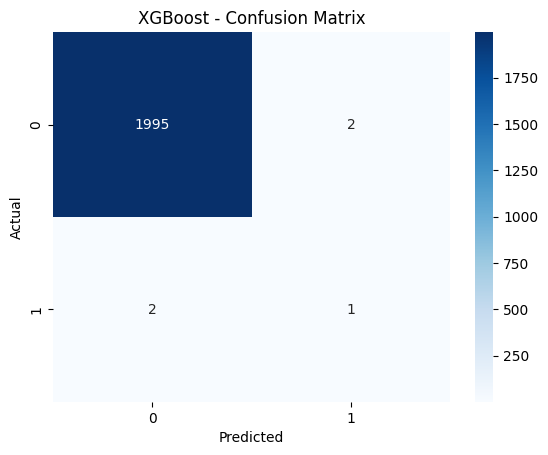

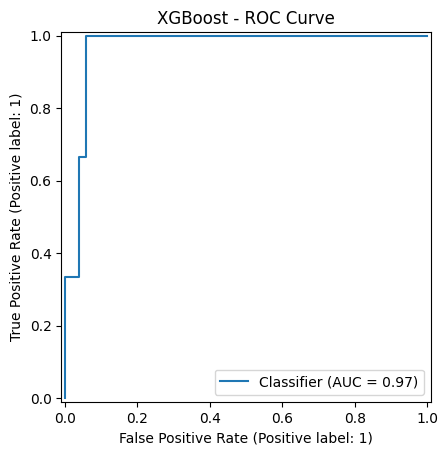

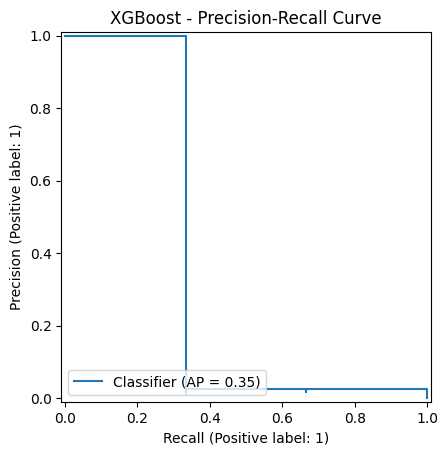

In [24]:
xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    use_label_encoder=False
)

param_grid_xgb = {
    "n_estimators": [100, 200],   #n_estimators = Number of boosting step ,More steps --> stronger learner
    "max_depth": [3, 6],          #Complexity of each tree Controls overfitting
    "learning_rate": [0.1, 0.01],  #learning_rate = How fast the model learns Smaller value --> slow but accurate learning Bigger value --> fast but risky (overfitting)
    "subsample": [0.8, 1.0]        #How much data each tree sees Less than 1.0 --> adds randomness → reduces overfitting
}

grid_xgb = GridSearchCV(
    xgb,
    param_grid=param_grid_xgb,
    cv=3,
    scoring="recall",
    n_jobs=-1,
    verbose=1
)

grid_xgb.fit(X_train_bal, y_train_bal)
print("Best XGB params:", grid_xgb.best_params_)

best_xgb = grid_xgb.best_estimator_
xgb_metrics = evaluate_model("XGBoost", best_xgb, X_test_processed, y_test)


In [25]:
#the model raises some false alarms (false positives), but at least it is attempting to detect fraud.

Model 3: SVM + GridSearch

In [26]:
#Support Vector Machine
#Fraud points are mostly on one side
#Normal points on the other
#SVM finds the best possible dividing line between them.

In [ ]:
svm_clf = SVC(probability=True, random_state=42)

param_grid_svm = {
    "C": [0.1, 1, 10],             #How strict the boundary should be Small C --> allows misclassification Large C --> tries to classify everything correctly (can overfit)
    "kernel": ["rbf", "linear"],   #Shape of the separating boundary linear --> straight line ,rbf --> curved boundary (more powerful)
    "gamma": ["scale", "auto"]    #How far the influence of one point spreads High gamma → very tight boundaries → overfitting Low gamma → smoother boundary
}

grid_svm = GridSearchCV(
    svm_clf,
    param_grid=param_grid_svm,
    cv=3,
    scoring="recall",
    n_jobs=-1,
    verbose=1
)

grid_svm.fit(X_train_bal, y_train_bal)
print("Best SVM params:", grid_svm.best_params_)

best_svm = grid_svm.best_estimator_
svm_metrics = evaluate_model("SVM", best_svm, X_test_processed, y_test)

In [27]:
#as it's taking alot of time ,better use a faster model


========== Fast Linear SVM ==========
Accuracy : 0.882
Precision: 0.012552301255230125
Recall   : 1.0
F1-score : 0.024793388429752067
AUC-ROC  : 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.88      0.94      1997
           1       0.01      1.00      0.02         3

    accuracy                           0.88      2000
   macro avg       0.51      0.94      0.48      2000
weighted avg       1.00      0.88      0.94      2000



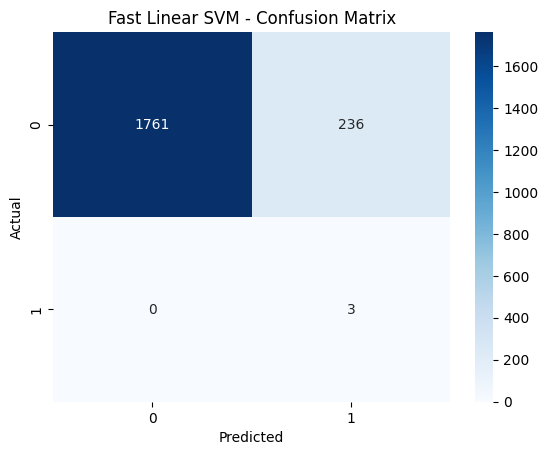

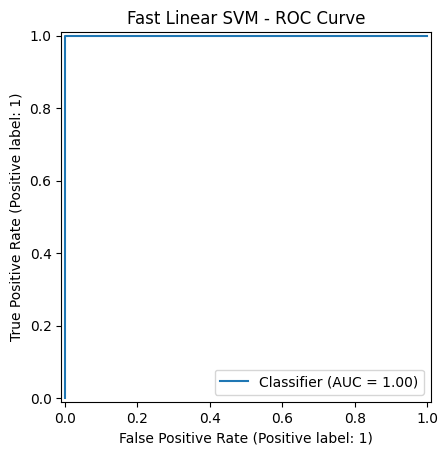

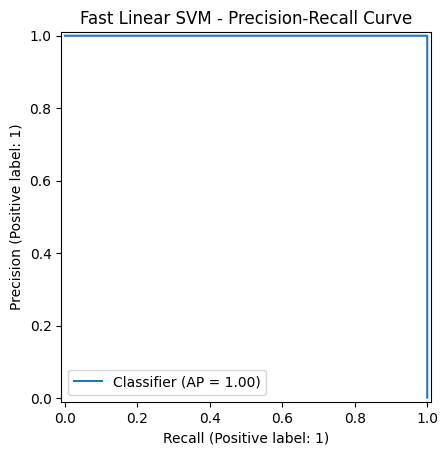

In [28]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

# Fast linear SVM (no kernel trick)
svm_fast = LinearSVC(C=1.0, class_weight='balanced', max_iter=5000)

# Calibrate so we can get probability scores for ROC/AUC
svm_fast = CalibratedClassifierCV(svm_fast)

svm_fast.fit(X_train_bal, y_train_bal)

svm_metrics = evaluate_model(
    "Fast Linear SVM",
    svm_fast,
    X_test_processed,
    y_test
)


In [19]:
results = pd.DataFrame([rf_metrics, xgb_metrics, svm_metrics])
results

,model,accuracy,precision,recall,f1,auc
0,Random Forest,0.9985,0.000000,0.000000,0.000000,0.998665
1,XGBoost,0.9980,0.333333,0.333333,0.333333,0.967952
2,Fast Linear SVM,0.9985,0.000000,0.000000,0.000000,1.000000


In [ ]:
#let's try using a lower threshold 0.3 instead of 0.5 to increase recall and rerun the models

In [29]:
results = pd.DataFrame([rf_metrics, xgb_metrics, svm_metrics])
results

,model,accuracy,precision,recall,f1,auc
0,Random Forest,0.9985,0.000000,0.000000,0.000000,0.998665
1,XGBoost,0.9980,0.333333,0.333333,0.333333,0.967952
2,Fast Linear SVM,0.8820,0.012552,1.000000,0.024793,1.000000


In [30]:
# SVM is Extremely aggressive Flags almost everything as fraud Not usable in real banking systems even though it has higher recall
#random forest is out of discussion
# clearly best performing model is XGBoost

In [31]:
#     SHAP ON XGBoost

In [32]:
# Ensure DataFrames with correct feature names
X_train_df = pd.DataFrame(X_train_bal, columns=feature_names)
X_test_df  = pd.DataFrame(X_test_processed, columns=feature_names)

In [33]:
shap.initjs()

explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_train_df)


In [34]:
# Mean absolute SHAP value per feature
shap_abs_mean = np.abs(shap_values).mean(axis=0)

shap_importance = pd.DataFrame({
    "feature": feature_names,
    "mean_abs_shap": shap_abs_mean
}).sort_values(by="mean_abs_shap", ascending=False)

shap_importance


,feature,mean_abs_shap
18,diffOrig,4.763482
20,errorBalanceOrig,1.269670
21,errorBalanceDest,1.130402
9,step,0.806985
2,newbalanceOrig_log,0.273200
3,oldbalanceDest_log,0.122445
10,amount,0.090415
13,oldbalanceDest,0.028292
16,amount_capped,0.015668
1,oldbalanceOrg_log,0.002745


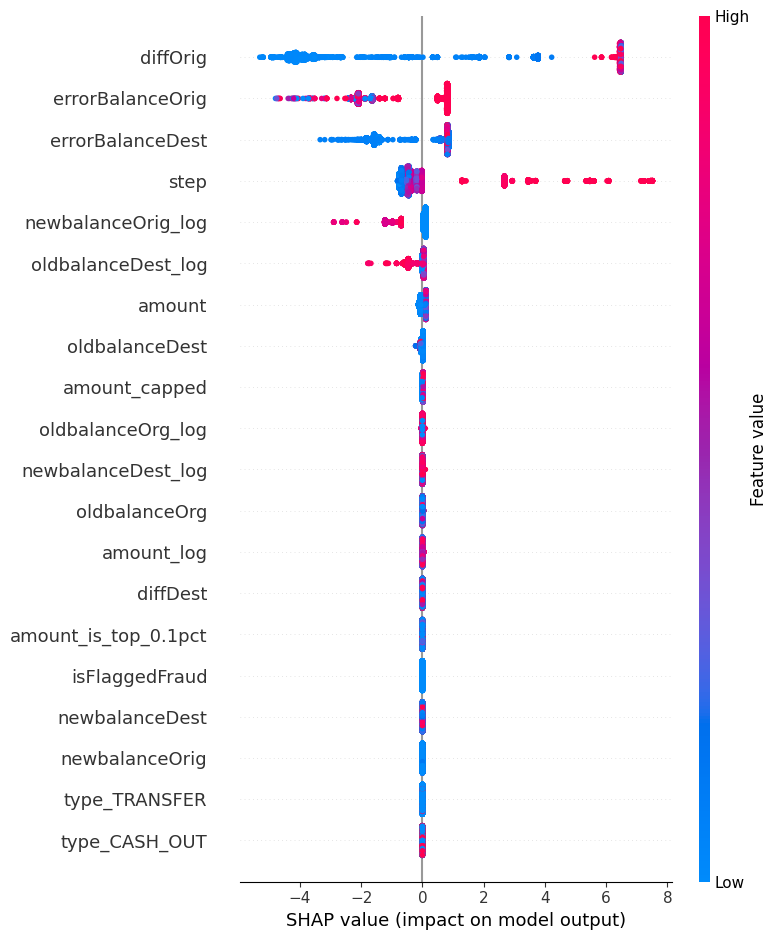

In [35]:
#beeswarm plot 
shap.summary_plot(shap_values, X_train_df)


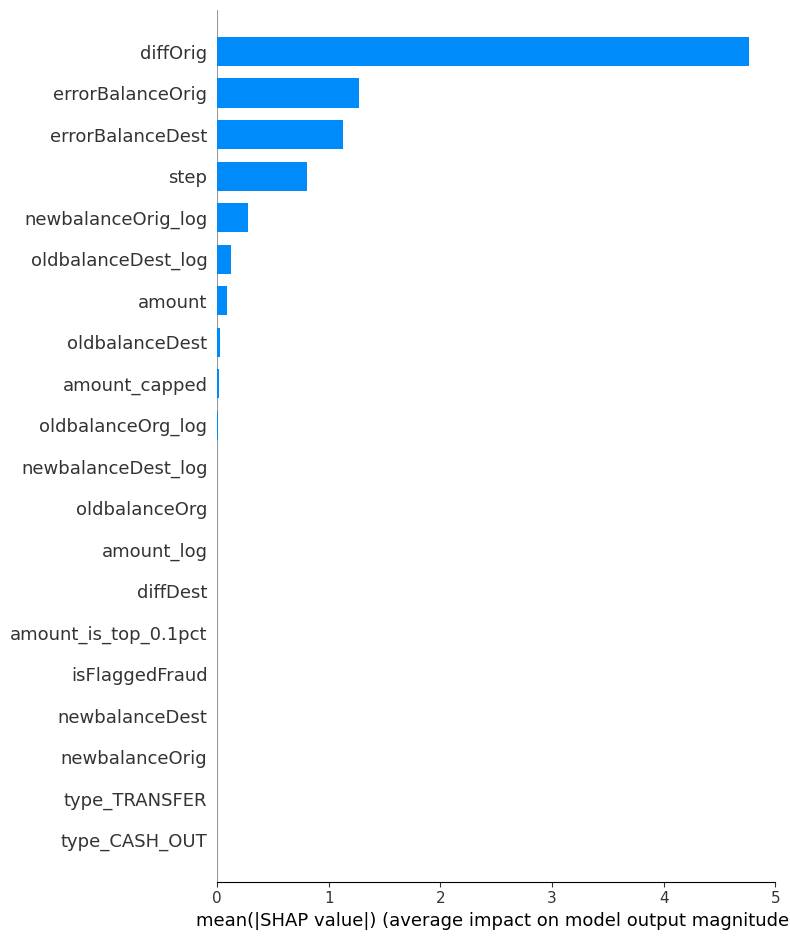

In [37]:
#Bar summary plot
shap.summary_plot(shap_values, X_train_df, plot_type="bar")


In [38]:
# Find a fraud case index from test set
fraud_indices = y_test[y_test == 1].index
idx = fraud_indices[0]    # first fraud case

x_single = X_test_df.loc[[idx]]


In [39]:
shap_single = explainer.shap_values(x_single)


In [40]:
#force plot
shap.force_plot(
    explainer.expected_value,
    shap_single,
    x_single
)

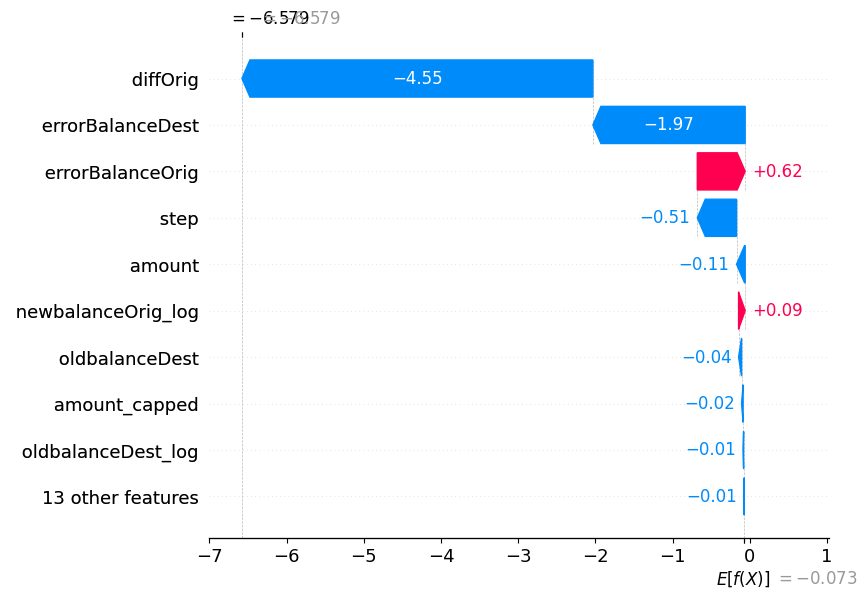

In [44]:
#waterfall plot
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value,
    shap_single[0],
    x_single.iloc[0]
)

In [42]:
#picking one non- fraud case now

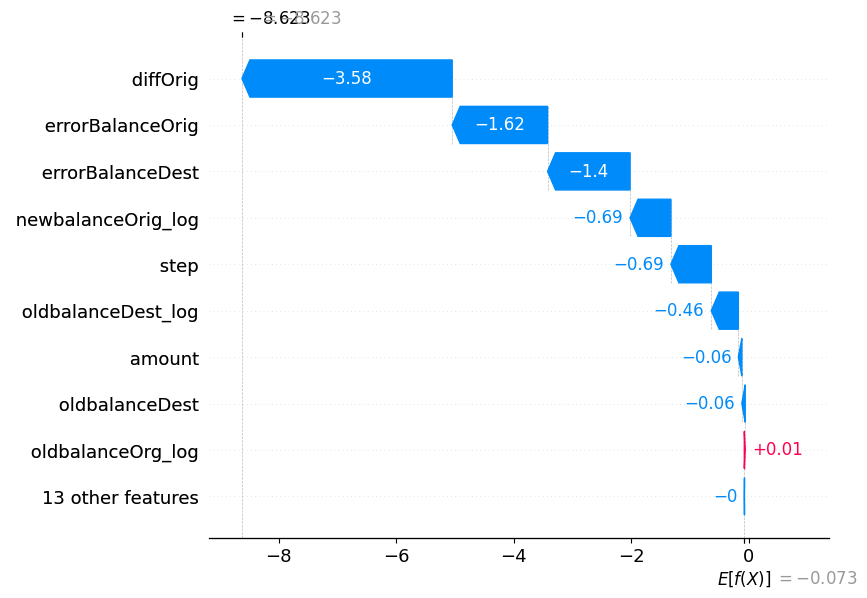

In [45]:
# pick a non-fraud case
normal_indices = y_test[y_test == 0].index
idx2 = normal_indices[0]

x_single_normal = X_test_df.loc[[idx2]]
shap_single_normal = explainer.shap_values(x_single_normal)

shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value,
    shap_single_normal[0],
    x_single_normal.iloc[0]
)


In [46]:
#SHAP analysis shows that transaction amount, error balance features, and transaction type contribute most to fraud prediction.
#Positive SHAP values increase the likelihood of a transaction being classified as FRRAUD, 
#while negative values reduce it. Transactions with unusually high amounts and large balance inconsistencies are strongly flagged by the model.